In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import sys
sys.path.append('../')
# Scientific 

import numpy as np
import random

import Train
from tqdm import tqdm
import matplotlib.pyplot as plt

# Machine learning

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report
from keras.utils import to_categorical

import temperature_scaling
from scipy.special import softmax

Using TensorFlow backend.


In [4]:
# Read in data wrt kic and fill etc.
NDAYS = -1
dataset = 'KIC'
accounting_for_TESS = False #True
df = pd.read_csv('../Colours_New_Gaps_output_data_noise_'+str(dataset)+'_'+str(NDAYS)+'_APOKASC.csv')
bad_kics = [10403036, 9846355, 5004660, 4936438, 6450613, 10597648, 5395942]
df = df[~df.KIC.isin(bad_kics)] 

# Set up training class
CLP = Train.Train(df, dataset, NDAYS)
# Preprocess
CLP.preprocess_data()
# Set up data for training
CLP.setup_for_training(features=['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag'])

# Extract the train and valid (used for validation) dataframes from the train_df
train_features, valid_features, y_train, y_valid = CLP.X_train.drop(['KIC', 'numax'], axis=1), CLP.X_test.drop(['KIC', 'numax'], axis=1), CLP.Y_train, CLP.Y_test

../Train.py:95: RuntimeWarning: divide by zero encountered in log10
  self.df['running_var'] = np.log10(np.abs(self.df['running_var']))
../Train.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df['KIC'] = self.df['KIC'].astype(int)


['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag']


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [5]:
params = {
    'n_estimators': 696,
    'eta': 0.35,
    'max_depth': 10,
    'min_child_weight': 5.0,
    'subsample': 0.75,
    'gamma': 7.5,
    'colsample_bytree': 1.0,
    'eval_metric': 'mlogloss',
    'objective': 'multi:softprob',
    'num_class': 5,
    'nthread': 4,
    'silent': 1,
    'seed': 0
}

In [6]:
num_round = int(params['n_estimators'])

dtrain = CLP.xg_train #xgb.DMatrix(train_features, label=y_train)
dvalid = CLP.xg_test #xgb.DMatrix(valid_features, label=y_valid)

gbm_model = xgb.train(params, dtrain, num_round,
                      verbose_eval=True)
predictions = gbm_model.predict(dvalid,
                                ntree_limit=gbm_model.best_iteration)
#print(predictions)
loss = log_loss(y_valid, predictions)
full_valid = CLP._create_full_class(y_valid)
full_pred = CLP._create_full_class(np.argmax(predictions, axis=1))
# TODO: Add the importance for the selected features
print("Score {0}".format(loss))
print("Accuracy {}".format(accuracy_score(y_valid, np.argmax(predictions, axis=1))))
print("Full accuracy {}".format(accuracy_score(full_valid, full_pred)))
print(classification_report(y_valid, np.argmax(predictions, axis=1)))
print(classification_report(full_valid, full_pred))

Score 0.2605693551476994
Accuracy 0.9022491349480969
Full accuracy 0.9178200692041523
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       152
           1       0.96      0.95      0.96       159
           2       0.90      0.79      0.84       736
           3       0.82      0.95      0.88       727
           4       0.99      0.98      0.99       538

   micro avg       0.90      0.90      0.90      2312
   macro avg       0.93      0.91      0.92      2312
weighted avg       0.91      0.90      0.90      2312

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1047
           1       0.82      0.95      0.88       727
           2       0.99      0.98      0.99       538

   micro avg       0.92      0.92      0.92      2312
   macro avg       0.93      0.93      0.93      2312
weighted avg       0.92      0.92      0.92      2312



In [8]:
new_model = temperature_scaling.ModelwithTemperature(gbm_model)

In [9]:
valid_labels = to_categorical(y_valid.values, num_classes=5)
#print(valid_labels)

In [10]:
new_model.set_temperature(dvalid, valid_labels)

[1 4 3 ... 4 3 2] [1 4 3 ... 4 2 2]
Before temperature scaling - NLL: -11.845077145058392, ECE: 0.018807533522584418
      fun: 0.2595318972024099
 hess_inv: array([[1.96828791]])
      jac: array([8.52718949e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([0.94067001])
Optimal Temperature: [0.94067003]
[1 4 3 ... 4 3 2] [1 4 3 ... 4 2 2]
After temperature scaling - NLL: -12.592170550058855, ECE: 0.013870689989508609


In [11]:
new_predictions = softmax(new_model.predict(dvalid), axis=1)

In [12]:
full_preds = np.c_[new_predictions[:,:3].sum(axis=1), new_predictions[:,3:]]
print(np.shape(full_preds))

(2312, 3)


In [13]:
#print(predictions)
loss = log_loss(y_valid, new_predictions)
full_valid = CLP._create_full_class(y_valid)
full_pred = CLP._create_full_class(np.argmax(new_predictions, axis=1))
# TODO: Add the importance for the selected features
print("Score {0}".format(loss))
print("Accuracy {}".format(accuracy_score(y_valid, np.argmax(new_predictions, axis=1))))
print("Full accuracy {}".format(accuracy_score(full_valid, full_pred)))
print(classification_report(y_valid, np.argmax(new_predictions, axis=1)))
print(classification_report(full_valid, full_pred))

Score 0.25953189720522846
Accuracy 0.902681660899654
Full accuracy 0.9182525951557093
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       152
           1       0.96      0.95      0.96       159
           2       0.90      0.79      0.84       736
           3       0.82      0.95      0.88       727
           4       0.99      0.98      0.99       538

   micro avg       0.90      0.90      0.90      2312
   macro avg       0.93      0.91      0.92      2312
weighted avg       0.91      0.90      0.90      2312

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1047
           1       0.82      0.95      0.88       727
           2       0.99      0.98      0.99       538

   micro avg       0.92      0.92      0.92      2312
   macro avg       0.93      0.93      0.93      2312
weighted avg       0.92      0.92      0.92      2312



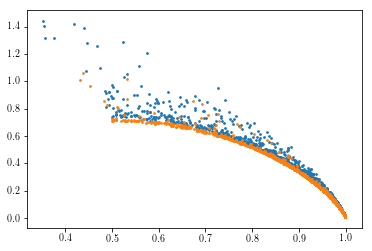

In [14]:
uncertainty = -1*np.sum(new_predictions * np.log(new_predictions), axis=1)
new_unc = -1 * np.sum(full_preds * np.log(full_preds), axis=1)
plt.scatter(np.max(new_predictions, axis=1), uncertainty, s=3)
plt.scatter(np.max(full_preds, axis=1), new_unc, s=3)

In [15]:
def make_model_diagrams(outputs, labels, n_bins=10):
    """
    outputs - a torch tensor (size n x num_classes) with the outputs from the final linear layer
    - NOT the softmaxes
    labels - a torch tensor (size n) with the labels
    """
    softmaxes = softmax(outputs, axis=1)
    confidences, predictions = np.max(softmaxes, axis=1), np.argmax(softmaxes, axis=1)
    #labels = to_categorical(labels.values)
    accuracies = (predictions == labels.values) * 1    
    #print(accuracies)
    # Reliability diagram
    bins = np.linspace(0, 1., n_bins + 1)
    #bins[-1] = 1.0001
    width = bins[1] - bins[0]
    #bin_indices = [confidences.ge(bin_lower) * confidences.lt(bin_upper) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    bin_indices = [((confidences > bin_lower) & (confidences < bin_upper)) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    label_bins = [labels.values[bin_index] for bin_index in bin_indices]
    bin_corrects = np.array([np.mean(accuracies[bin_index]) for bin_index in bin_indices])
    bin_scores = np.array([np.mean(confidences[bin_index]) for bin_index in bin_indices])
    #print(label_bins)
    #print(bin_corrects)
    #print(bins[:-1][np.nanargmax(bin_corrects)])
    confs = plt.bar(bins[:-1], bin_corrects, width=width, edgecolor='k', align='edge')
    gaps = plt.bar(bins[:-1], (bin_scores - bin_corrects), bottom=bin_corrects, align='edge', color=[1, 0.7, 0.7], alpha=0.5, width=width, hatch='//', edgecolor='r')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    #plt.legend([confs, gaps], ['Outputs', 'Gap'], loc='best', fontsize='small')
    plt.xlim(0, 1)
    # Clean up
    plt.ylabel('Accuracy', fontsize=18)
    plt.xlabel('Confidence', fontsize=18)
    return bins[:-1], label_bins, bin_corrects

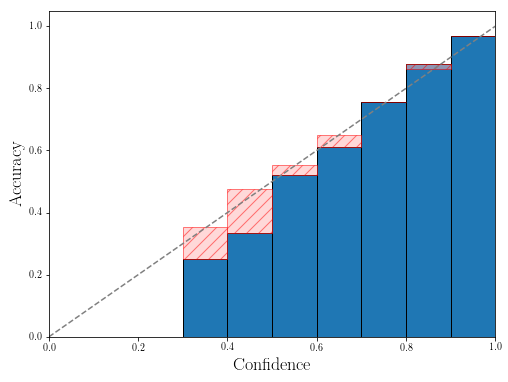

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


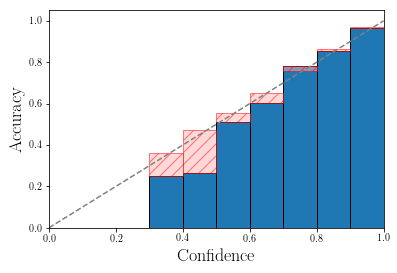

In [21]:
fig = plt.figure(figsize=(8, 6))
bins, labs, corr = make_model_diagrams(gbm_model.predict(dvalid, output_margin=True), y_valid, n_bins=10)
plt.savefig('/home/kuszlewicz/Dropbox/Reliability_plot.pdf')
plt.show()
bins2, labs2, corr2 = make_model_diagrams(new_model.predict(dvalid), y_valid, n_bins=10)

In [49]:
list(zip(corr, bins, labs))

[(nan, 0.0, array([], dtype=int64)),
 (nan, 0.04, array([], dtype=int64)),
 (nan, 0.08, array([], dtype=int64)),
 (nan, 0.12, array([], dtype=int64)),
 (nan, 0.16, array([], dtype=int64)),
 (nan, 0.2, array([], dtype=int64)),
 (nan, 0.24, array([], dtype=int64)),
 (1.0, 0.28, array([4])),
 (1.0, 0.32, array([4, 4, 4])),
 (0.6666666666666666, 0.36, array([4, 0, 4])),
 (0.5, 0.4, array([4, 2, 4, 4])),
 (0.5333333333333333,
  0.44,
  array([4, 0, 0, 3, 4, 2, 0, 2, 4, 2, 2, 4, 2, 4, 2])),
 (0.45454545454545453,
  0.48,
  array([3, 2, 2, 2, 4, 4, 2, 2, 2, 3, 2, 0, 2, 3, 2, 2, 2, 3, 2, 3, 2, 4,
         2, 3, 3, 2, 1, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 0, 2, 3, 2, 2, 0, 2,
         0, 3, 2, 2, 2, 2, 3, 0, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 4,
         3, 2, 3, 3, 0, 0, 2, 1, 2, 3, 3, 2, 2, 3, 3, 2, 4, 3, 3, 2, 3, 2,
         0, 2, 2, 2, 3, 4, 2, 2, 3, 2, 3, 3, 3, 3, 3, 0, 2, 3, 1, 3, 4, 3,
         3, 3, 3, 4, 2, 3, 2, 3, 2, 3, 2])),
 (0.4794520547945205,
  0.52,
  array([2, 3, 2, 2, 2, 4, 2,

In [27]:
labs

[array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([4]),
 array([4, 4]),
 array([0]),
 array([2, 2, 2]),
 array([0, 0, 3, 2, 2, 2, 2, 3, 3, 2, 0, 3, 3, 3]),
 array([3, 0, 2, 0, 0, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 1, 2, 3, 4,
        3, 3, 3, 4, 3, 2, 3, 3, 3, 2, 2]),
 array([4, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 0, 2, 3, 1, 3, 3, 3, 3, 3, 2,
        0, 1, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2]),
 array([1, 2, 3, 3, 3, 1, 2, 0, 3, 3, 2, 3, 1, 3, 2, 3, 3, 2, 3, 3, 3, 2,
        2, 2, 2, 3, 3, 2, 3, 3, 0, 2, 3, 3, 2, 2]),
 array([3, 2, 2, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3,
        3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 2, 2]),
 array([2, 2, 3, 2, 3, 3, 2, 1, 3, 2, 3, 3, 3, 0, 2, 3, 3, 3, 4, 2, 3, 0,
        2, 4, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2]),
 array([3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2

In [215]:
fig = make_model_diagrams(gbm_model.predict(dvalid, output_margin=True), y_valid, n_bins=25)
plt.savefig('/home/kuszlewicz/Dropbox/Reliability_plot.pdf')
plt.show()
fig = make_model_diagrams(new_model.predict(dvalid), y_valid, n_bins=25)

(64,)
(2357, 5)
[0. 2. 2. 3. 2. 0. 0. 2. 2. 0. 3. 0. 0. 2. 0. 0. 0. 0. 0. 3. 0. 0. 3. 0.
 3. 0. 3. 0. 4. 0. 3. 0. 1. 3. 0. 0. 2. 2. 0. 0. 0. 4. 0. 2. 0. 2. 0. 0.
 0. 1. 0. 0. 2. 2. 3. 3. 3. 0. 2. 0. 2. 3. 0. 0.]


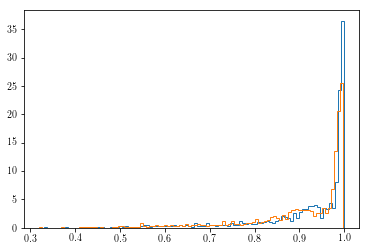

In [92]:
plt.hist(np.max(softmax(new_model.predict(dvalid), axis=1), axis=1), bins=100, histtype='step', density=True);
plt.hist(np.max(gbm_model.predict(dvalid), axis=1), bins=100, histtype='step', density=True);